## Libraries

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import copy
import random
import os
import math
import shutil
import tarfile
from urllib.request import urlretrieve

from collections import defaultdict
from IPython.display import FileLink

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import albumentations as A

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from sklearn.model_selection import train_test_split

from timeit import default_timer as timer
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset

In [ ]:
# эта функция нужна что бы посмотреть в итоге как выгядит модель
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

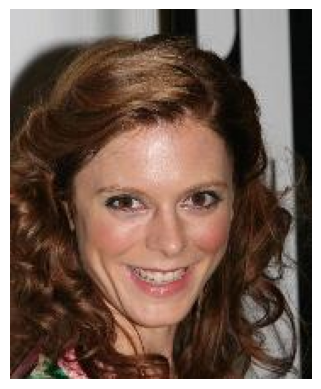

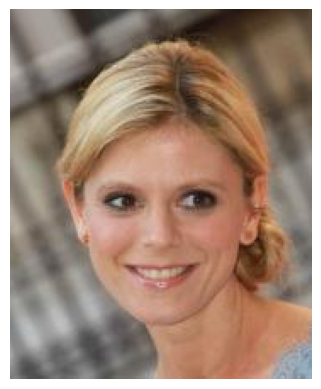

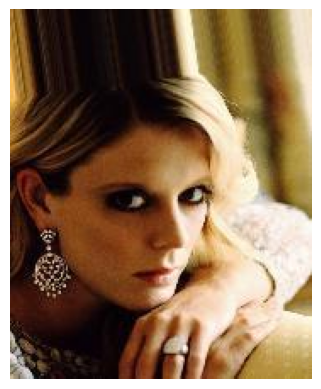

In [ ]:
# опредеяем пути и выведем несколько картинок
common_path = '/kaggle/input/faces/celebA_train_500/celebA_imgs/'
image_paths = [common_path+'011437.jpg', common_path+'037082.jpg', common_path+'055891.jpg']

for image_path in image_paths:
    if os.path.exists(image_path):
        # Открываем изображение
        image = Image.open(image_path)

        # Отображаем изображение
        plt.figure()  # Создаем новую фигуру
        plt.imshow(image)
        plt.axis('off')  # Скрыть оси
        plt.show()
    else:
        print(f"Файл {image_path} не найден.")

### мне показалось что удобно будет сделать словарь для быстрого поиска изображение и его класса

In [ ]:
id_dict = {} # создаем словарь с метками классов и списком фото к ним
with open('/kaggle/input/faces/celebA_train_500/celebA_anno.txt', 'r') as file:
    for line in file:
        curr_line = line.strip().split(' ')
        curr_id = int(curr_line[1])
        id_dict.setdefault(curr_id, [])
        id_dict[curr_id].append(curr_line[0])

In [ ]:
# делаем кастомную функцию для определения класса по фотке
def find_key_by_value(search_value, dictionary):
    for key, values in dictionary.items():
        if search_value in values:
            return key
    return None

In [ ]:
find_key_by_value('114109.jpg', id_dict) # тестим

5

In [ ]:
path = '/kaggle/input/faces/celebA_train_500/celebA_imgs'
pre_list_of_pictures = sorted(os.listdir(path))
list_of_pictures = []

# отбираем только размеченные фотки (оказалось что половина фоток не размечена..)
for x in pre_list_of_pictures:
    if find_key_by_value(x, id_dict) is not None:
        list_of_pictures.append(x)

In [ ]:
len(list_of_pictures)

12011

### так теперь создаем класс Faces что бы было удобнее манипулировать датасетом и создать даталоудер

In [ ]:
class Faces(Dataset):
    def __init__(self, images_filepaths, mode):
        self.images_filepaths = images_filepaths
        self.mode = mode # в зависимости от того train или val/test будет зависить список трансформаций

    def __len__(self):
        return len(self.images_filepaths)

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == 'test' or self.mode == 'val':
            transform = transforms.Compose([
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            augs = transforms.RandomChoice([
                transforms.Compose([
                    transforms.Resize(size=(224,224), antialias=True),
                    #transforms.CenterCrop(size=300),
                    #transforms.RandomCrop(250)
                ]),
                #transforms.RandomRotation(degrees=(-25,25)),
                transforms.RandomHorizontalFlip(p=0.9),
                #transforms.RandomVerticalFlip(p=0.9),
                transforms.Grayscale(num_output_channels=3),
                #transforms.ColorJitter(saturation=0.9),
                #transforms.ColorJitter(hue=0.45)

            ])
            transform = transforms.Compose([
                augs,
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        file = os.path.join(path, self.images_filepaths[index])
        x = self.load_sample(file)
        x = transform(x)
        label = find_key_by_value(self.images_filepaths[index], id_dict) # тут и понадобился словарь и кастомная функция

        return x, label

In [ ]:
# Сначала разделим на train и temp (где temp будет содержать val и test)
train_pictures, temp_pictures = train_test_split(list_of_pictures, test_size=0.2, random_state=42)

# Теперь разделим temp на val и test
val_pictures, test_pictures = train_test_split(temp_pictures, test_size=0.1, random_state=42)

# Вывод количества элементов в каждой выборке
print(f"Количество train картинок: {len(train_pictures)}")
print(f"Количество val картинок: {len(val_pictures)}")
print(f"Количество test картинок: {len(test_pictures)}")

Количество train картинок: 9608
Количество val картинок: 2162
Количество test картинок: 241


In [ ]:
train_dataset = Faces(train_pictures, 'train')
val_dataset = Faces(val_pictures, 'val')
test_dataset = Faces(test_pictures, 'test')

In [ ]:
batch_size = 16
num_workers = 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
  )

val_dataloader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

test_dataloader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

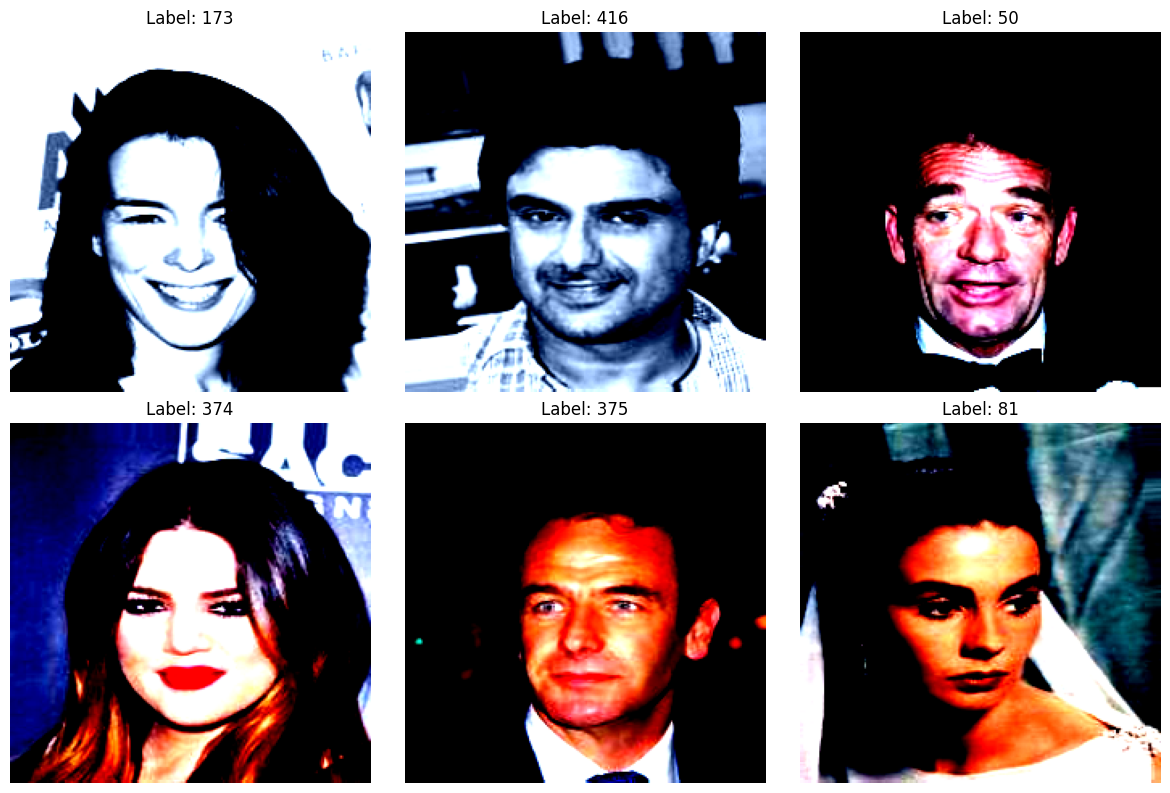

In [ ]:
# Функция для отображения изображений
def show_images(images, labels):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.flatten()
    for img, label, ax in zip(images, labels, axs):
        img = img.permute(1, 2, 0)  # Меняем оси, чтобы отобразить изображение
        img = img.numpy()  # Переводим в numpy массив
        ax.imshow(img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


data_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
# Извлечение и отображение первых 6 изображений
data_iter = iter(data_loader)
images, labels = next(data_iter)
show_images(images, labels)

In [ ]:
# удобная функция для посчета точности, делал ее еще на прошлых домашках
def calculate_accuracy(output, target):
    _, predicted = torch.max(output, dim=1)
    correct = (predicted == target).sum().item()
    total = target.size(0)
    accuracy = correct / total
    return accuracy

### train loop

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # переключаем модель в режим тренировки
    model.train()
    train_acc = 0
    train_loss = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(inputs)

        loss = loss_fn(output, labels.long())
        loss.backward()
        optimizer.step()
        accuracy = calculate_accuracy(output, labels)
        train_acc += accuracy
        train_loss += loss.item()
    return (train_loss/len(dataloader), train_acc/len(dataloader))

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # переключаем модель в режим валидации
    model.eval()
    test_acc = 0
    test_loss = 0
    best_acc = - np.inf
    best_weights = None
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            output = model(inputs)
            loss = loss_fn(output, labels.long())
            accuracy = calculate_accuracy(output, labels)
            test_acc += accuracy
            test_loss += loss.item()

    return (test_loss/len(dataloader), test_acc/len(dataloader))



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Создаем пустой словарь и логгируем лоссы и метрики на трейне и вале
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # будем сохранять лучшие веса модели относительно метрики на валидации
    best_acc = - np.inf
    best_weights = None
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # если точность после очередной эпохи лучше - то сохраняем веса модели
        if test_acc > best_acc:
            best_acc = test_acc
            best_weights = copy.deepcopy(model.state_dict())

        # Выводим логи
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # собственно сохраняем логи в словарь

        results['train_loss'].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        model.load_state_dict(best_weights) # загружаем лучшие веса
        torch.save({
                'epoch': epochs,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, f"{epochs}_iter.pth")

    # Возвращаем словарь логов
    return results

# Долго пытался выбрать модель для backbone'a, в итоге остановился на Efficient net

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
EN_model = EfficientNet.from_pretrained('efficientnet-b5')

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=303ca6ec8934037a3724131bbf63322f25100c28613876d7988f3736b37c0ee1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 233MB/s]  


Loaded pretrained weights for efficientnet-b5


In [ ]:
EN_layers = [name for name, _ in EN_model.named_parameters()] # сохраняем все слои в список
len(EN_layers) # смотрим сколько слоев есть вообще

506

In [ ]:
freeze = EN_layers[:400] # будем замораживать первые 400 из 506
for name, param in EN_model.named_parameters():
    if name in freeze:
        param.requires_grad = False

# изменим классификационную голову на 500 классов
num_ftrs = EN_model._fc.in_features
EN_model._fc = nn.Linear(num_ftrs, 500)

summary(EN_model,
        input_size=(16, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 500]            --                   Partial
├─Conv2dStaticSamePadding (_conv_stem)                       [16, 3, 224, 224]    [16, 48, 112, 112]   1,296                False
│    └─ZeroPad2d (static_padding)                            [16, 3, 224, 224]    [16, 3, 225, 225]    --                   --
├─BatchNorm2d (_bn0)                                         [16, 48, 112, 112]   [16, 48, 112, 112]   (96)                 False
├─MemoryEfficientSwish (_swish)                              [16, 48, 112, 112]   [16, 48, 112, 112]   --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   Partial
│    └─MBConvBlock (0)                                       [16, 48, 112, 112]   [16, 2

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(EN_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5) # добавим lr-reductor))
n_epochs = 10

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# таймер
start_time = timer()

# собственно обучение и сохранение логов для дальнейшего отображения
results = train(model=EN_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# посмотрим сколько времени это заняло
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.6969 | train_acc: 0.0484 | test_loss: 4.6523 | test_acc: 0.1448
Epoch: 2 | train_loss: 4.4005 | train_acc: 0.2039 | test_loss: 3.4544 | test_acc: 0.3084
Epoch: 3 | train_loss: 3.3342 | train_acc: 0.3545 | test_loss: 2.6789 | test_acc: 0.4462
Epoch: 4 | train_loss: 2.6325 | train_acc: 0.4627 | test_loss: 2.2259 | test_acc: 0.5244
Epoch: 5 | train_loss: 2.1277 | train_acc: 0.5414 | test_loss: 2.0391 | test_acc: 0.5565
Epoch: 6 | train_loss: 1.7650 | train_acc: 0.6123 | test_loss: 1.7796 | test_acc: 0.6158
Epoch: 7 | train_loss: 1.4818 | train_acc: 0.6678 | test_loss: 1.6931 | test_acc: 0.6213
Epoch: 8 | train_loss: 1.3118 | train_acc: 0.6947 | test_loss: 1.6177 | test_acc: 0.6466
Epoch: 9 | train_loss: 1.1680 | train_acc: 0.7313 | test_loss: 1.6321 | test_acc: 0.6475
Epoch: 10 | train_loss: 1.0185 | train_acc: 0.7536 | test_loss: 1.5973 | test_acc: 0.6521
[INFO] Total training time: 1347.186 seconds


In [ ]:
# докрутим еще 10 эпох
n_epochs = 10
results = train(model=EN_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6883 | train_acc: 0.8396 | test_loss: 1.4105 | test_acc: 0.6921
Epoch: 2 | train_loss: 0.5448 | train_acc: 0.8776 | test_loss: 1.3867 | test_acc: 0.6981
Epoch: 3 | train_loss: 0.4236 | train_acc: 0.9086 | test_loss: 1.3764 | test_acc: 0.6990
Epoch: 4 | train_loss: 0.3409 | train_acc: 0.9306 | test_loss: 1.3696 | test_acc: 0.6994
Epoch: 5 | train_loss: 0.2629 | train_acc: 0.9505 | test_loss: 1.3613 | test_acc: 0.6999
Epoch: 6 | train_loss: 0.1966 | train_acc: 0.9667 | test_loss: 1.3546 | test_acc: 0.7096
Epoch: 7 | train_loss: 0.1378 | train_acc: 0.9815 | test_loss: 1.3540 | test_acc: 0.7059
Epoch: 8 | train_loss: 0.1016 | train_acc: 0.9899 | test_loss: 1.3618 | test_acc: 0.7050
Epoch: 9 | train_loss: 0.0685 | train_acc: 0.9956 | test_loss: 1.3612 | test_acc: 0.7063
Epoch: 10 | train_loss: 0.0399 | train_acc: 0.9983 | test_loss: 1.3606 | test_acc: 0.7068
[INFO] Total training time: 1344.344 seconds


# результат неутилиштельный...

In [ ]:
test_step(EN_model, test_dataloader, loss_fn, device)

(1.2873714175075293, 0.66015625)

In [ ]:
torch.save(EN_model.state_dict(), 'EN_model.pth') # сохраняем веса

In [ ]:
from IPython.display import FileLink
FileLink(r'EN_model.pth') # скачиваем веса

/kaggle/working/EN_model.pth

### отрисуем что получилось

In [ ]:
def plot_training_history(histories, model_names, metric='Accuracy'):
    plt.figure(figsize=(12, 6), facecolor='lightgrey')

    # График потерь на обучающем и тестовом наборах данных
    plt.subplot(1, 2, 1)
    colors = ['blue', 'red', 'green', 'orange']  # Список цветов для графиков
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], '--', color='red', label=f'Training loss - {name}')
        plt.plot(epochs, history['test_loss'], color='red', label=f'Validation loss - {name}')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # График точности на обучающем и тестовом наборах данных
    plt.subplot(1, 2, 2)
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['train_acc']) + 1)
        plt.plot(epochs, history['train_acc'], '--', color='blue', label=f'Training metric - {name}')
        plt.plot(epochs, history['test_acc'], color='blue', label=f'Validation metric - {name}')

    plt.title('Training and Validation {}'.format(metric))
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

    plt.suptitle('Training History')
    plt.tight_layout()
    plt.show()

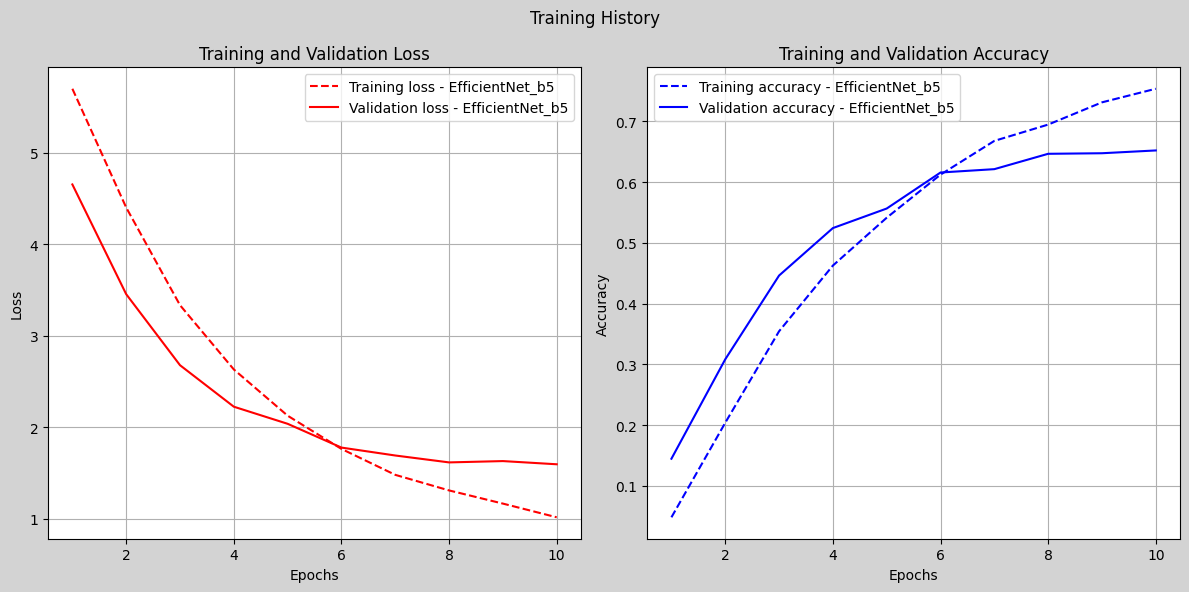

In [ ]:
plot_training_history([results], ['EfficientNet_b5'])

# Попробуем с триплет лоссом

### Придется переписать почти все: как минимум нужно создать отдельные словари для тренировочных данных, валидации и теста, поскольку мы будем выбирать positive / negative не из общего пула всех картинок а из конкретного набора данных (трейн\тест\вал)

In [ ]:
# Сначала разделим на train и temp (где temp будет содержать val и test)
train_pictures, temp_pictures = train_test_split(list_of_pictures, test_size=0.2, random_state=42)

# Теперь разделим temp на val и test
val_pictures, test_pictures = train_test_split(temp_pictures, test_size=0.1, random_state=42)

# Вывод количества элементов в каждой выборке
print(f"Количество train картинок: {len(train_pictures)}")
print(f"Количество val картинок: {len(val_pictures)}")
print(f"Количество test картинок: {len(test_pictures)}")


# создаем три разных словаря для тренировки, валидации и тестирования
train_id_dict = {}
val_id_dict = {}
test_id_dict = {}


list_of_lables = []
with open('/kaggle/input/faces/celebA_train_500/celebA_anno.txt', 'r') as file:
    for line in file:
        curr_line = line.strip().split(' ')
        list_of_lables.append(curr_line)

for file in train_pictures:
    for couple in list_of_lables:
        if file in couple:
            indx = int(couple[1])
            train_id_dict.setdefault(indx, [])
            train_id_dict[indx].append(file)

for file in val_pictures:
    for couple in list_of_lables:
        if file in couple:
            indx = int(couple[1])
            val_id_dict.setdefault(indx, [])
            val_id_dict[indx].append(file)

for file in test_pictures:
    for couple in list_of_lables:
        if file in couple:
            indx = int(couple[1])
            test_id_dict.setdefault(indx, [])
            test_id_dict[indx].append(file)

Количество train картинок: 9608
Количество val картинок: 2162
Количество test картинок: 241


### Тут создаем EfficientNet b2 и ResNet18 меняя последний слой на слой эмбеддинга размером 512 и батчнормализацию без обучения, создаем шаблон triplet_loss и triplet_dataset

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=024c1f74778b26843b6fe3a924858e750b4ee2ac51e2d663767abcbd800ab388
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
# проще модель конечно в виде класса делать:

class ModifiedEfficientNet(nn.Module):
    def __init__(self, embedding_dim=512):
        super(ModifiedEfficientNet, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b2')

        self.EN_layers = [name for name, _ in self.efficientnet.named_parameters()]
        self.freeze = self.EN_layers[:90] # методом проб и ошибок я дошел до того что замораживать надо первые 90 слоев
        for name, param in self.efficientnet.named_parameters():
            if name in self.freeze:
                param.requires_grad = False

        # Изменяем последний слой EfficientNet на Linear слой с нужным размером эмбеддингов
        self.efficientnet._fc = nn.Linear(self.efficientnet._fc.in_features, embedding_dim)

    def forward(self, x):
        embeddings = F.normalize(self.efficientnet(x), dim=1)
        return embeddings

class ResNet18Embedding(nn.Module):
    def __init__(self):
        super(ResNet18Embedding, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                                       nn.BatchNorm1d(512, affine=False, track_running_stats=False))

    def forward(self, x):
        return self.model(x)

# Функция потерь Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss_fn = nn.TripletMarginLoss(margin=self.margin, p=2)

    def forward(self, anchor, positive, negative):
        return self.loss_fn(anchor, positive, negative)



class TripletDataset(Dataset):
    def __init__(self, images_filepaths, id_dict):
        self.images_filepaths = images_filepaths
        self.dict = id_dict

    def __len__(self):
        return len(self.images_filepaths)

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

        transform = transforms.Compose([
            transforms.Resize(size=(224,224), antialias=True),
            transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        # получаем сначала якорь и его лейбл
        anchor_file = os.path.join(path, self.images_filepaths[index])
        anchor = self.load_sample(anchor_file)
        anchor = transform(anchor)
        anchor_label = find_key_by_value(self.images_filepaths[index], self.dict)

        # ищем рандомный позитивный семпл, но исключаем ту же картинку

        positive_files = [x for x in self.dict[anchor_label] if x != self.images_filepaths[index]]
        if len(positive_files):
            positive_file = random.choice(positive_files)
            positive_file = os.path.join(path, positive_file)
        else:
            positive_file = self.images_filepaths[index]
            positive_file = os.path.join(path, positive_file)
        positive = self.load_sample(positive_file)
        positive = transform(positive)

        # остается негативный семпл
        random_negative = list(self.dict.keys())
        random_negative.remove(anchor_label)
        random_negative = random.choice(random_negative)

        negative_files = [x for x in self.dict[random_negative]]
        negative_file = random.choice(negative_files)
        negative_file = os.path.join(path, negative_file)
        negative = self.load_sample(negative_file)
        negative = transform(negative)

        return anchor, positive, negative

### метриков будет Average Precision

In [ ]:
def calculate_AP(cos_sim_pos, cos_sim_neg):
    cos_sim_pos = cos_sim_pos.detach().cpu().numpy()
    cos_sim_neg = cos_sim_neg.detach().cpu().numpy()
    # Сортируем cos_sim_pos по убыванию
    sorted_indices = np.argsort(-cos_sim_pos)
    cos_sim_pos_sorted = cos_sim_pos[sorted_indices]
    cos_sim_neg_sorted = cos_sim_neg[sorted_indices]

    # Подсчитываем число истинных положительных
    num_positives = len(cos_sim_pos_sorted)

    # Вычисляем Precision и Recall
    precisions = []
    recalls = []
    num_true_positives = 0
    for i, (pos_score, neg_score) in enumerate(zip(cos_sim_pos_sorted, cos_sim_neg_sorted)):
        if pos_score >= neg_score:
            num_true_positives += 1
        precision = num_true_positives / (i + 1)
        recall = num_true_positives / num_positives
        precisions.append(precision)
        recalls.append(recall)

    # Вычисляем Average Precision (AP) как среднее значение Precision по всем уникальным значениям Recall
    recalls = np.asarray(recalls)
    precisions = np.asarray(precisions)
    ap = np.sum(precisions * np.diff(recalls, prepend=0))

    return ap

def metric(anchor_embs, pos_embs, neg_embs):
    # Преобразуем их в форму, где первое измерение будет батч_сайз
    batch_size = anchor_embs.size(0)

    # Разворачиваем тензоры в одномерные эмбеддинги
    anchor_emb = anchor_embs.view(batch_size, -1)
    positive_emb = pos_embs.view(batch_size, -1)
    negative_emb = neg_embs.view(batch_size, -1)

    # вычисляем косинусные расстояния между якорем и позитив и негатив
    cos_sim_pos = F.cosine_similarity(anchor_emb, positive_emb, dim=-1)
    cos_sim_neg = F.cosine_similarity(anchor_emb, negative_emb, dim=-1)

    return calculate_AP(cos_sim_pos, cos_sim_neg)

In [ ]:
train_dataset = TripletDataset(train_pictures, train_id_dict)
val_dataset = TripletDataset(val_pictures, val_id_dict)
test_dataset = TripletDataset(test_pictures, test_id_dict)

# убедимся что тройки из себя представляют действительно два изображения одного человека и третье негативное изображение

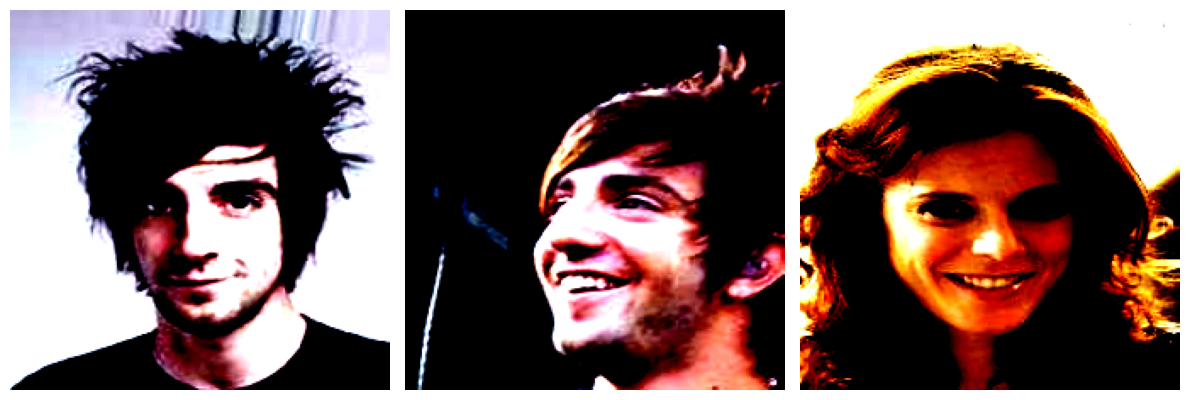

In [ ]:
imgs = train_dataset[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    img = img.permute(1, 2, 0)  # Меняем оси, чтобы отобразить изображение
    img = img.numpy()  # Переводим в numpy массив
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
batch_size = 64 # все таки 64 лучший батч_сайз
num_workers = 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
  )

val_dataloader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

test_dataloader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

In [ ]:
# почти тот же train loop но с маленькими изменениями
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss = 0
    train_score = 0

    # из dataloader'a достаем тройки: anchor, positive, negative; каждый размером 64х3х224х224
    for anchor, positive, negative in dataloader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()
        # получаем эмбеддинги
        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)
        # считаем АР и лосс
        score = metric(anchor_output, positive_output, negative_output)
        loss = loss_fn(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_score += score
    return (train_loss/len(dataloader), train_score/len(dataloader))

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    test_score = 0
    with torch.no_grad():
        for anchor, positive, negative in dataloader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            score = metric(anchor_output, positive_output, negative_output)
            loss = loss_fn(anchor_output, positive_output, negative_output)
            test_loss += loss.item()
            test_score += score
    return (test_loss/len(dataloader), test_score/len(dataloader))



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_score": [],
               "test_loss": [],
               "test_score" : []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_score = train_step(model=model,
                                  dataloader=train_dataloader,
                                  loss_fn=loss_fn,
                                  optimizer=optimizer,
                                  device=device)
        test_loss, test_score = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
            f"train_score: {train_score:.4f} | "
          f"test_loss: {test_loss:.4f} | "
            f"test_score: {test_score:.4f} "
        )

        results['train_loss'].append(train_loss)
        results["test_loss"].append(test_loss)
        results["train_score"].append(train_score)
        results["test_score"].append(test_score)

        torch.save({
                'epoch': epochs,
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"{epochs}_iter.pth")

    return results

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
triplet_loss = TripletLoss()
#model = ResNet18Embedding().to(device)
model = ModifiedEfficientNet().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 294MB/s]


Loaded pretrained weights for efficientnet-b2


# пробуем ResNet18

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 7, gamma=0.5)
n_epochs = 21

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=triplet_loss,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8363 | train_score: 0.6247 | test_loss: 2.1428 | test_score: 0.6904 
Epoch: 2 | train_loss: 1.9596 | train_score: 0.6960 | test_loss: 1.6789 | test_score: 0.7273 
Epoch: 3 | train_loss: 1.5339 | train_score: 0.7485 | test_loss: 1.2314 | test_score: 0.7852 
Epoch: 4 | train_loss: 1.3395 | train_score: 0.7591 | test_loss: 1.0109 | test_score: 0.8022 
Epoch: 5 | train_loss: 1.1323 | train_score: 0.7830 | test_loss: 0.9055 | test_score: 0.8265 
Epoch: 6 | train_loss: 1.0428 | train_score: 0.7905 | test_loss: 0.8591 | test_score: 0.8252 
Epoch: 7 | train_loss: 0.9201 | train_score: 0.8056 | test_loss: 0.8317 | test_score: 0.8162 
Epoch: 8 | train_loss: 0.8800 | train_score: 0.8066 | test_loss: 0.7726 | test_score: 0.8134 
Epoch: 9 | train_loss: 0.8058 | train_score: 0.8151 | test_loss: 0.8549 | test_score: 0.8199 
Epoch: 10 | train_loss: 0.7539 | train_score: 0.8207 | test_loss: 0.8518 | test_score: 0.8111 
Epoch: 11 | train_loss: 0.6967 | train_score: 0.8257 | test

In [ ]:
test_step(model, test_dataloader, triplet_loss, device)

(0.4954897502765936, 0.8546031895239152)

# Теперь EN b2

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 7, gamma=0.5)
n_epochs = 15

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=triplet_loss,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4373 | train_score: 0.7982 | test_loss: 0.3872 | test_score: 0.8305 
Epoch: 2 | train_loss: 0.3638 | train_score: 0.8432 | test_loss: 0.3590 | test_score: 0.8394 
Epoch: 3 | train_loss: 0.3149 | train_score: 0.8734 | test_loss: 0.3281 | test_score: 0.8586 
Epoch: 4 | train_loss: 0.3042 | train_score: 0.8788 | test_loss: 0.3112 | test_score: 0.8722 
Epoch: 5 | train_loss: 0.2823 | train_score: 0.8892 | test_loss: 0.3035 | test_score: 0.8794 
Epoch: 6 | train_loss: 0.2738 | train_score: 0.9024 | test_loss: 0.2971 | test_score: 0.8828 
Epoch: 7 | train_loss: 0.2539 | train_score: 0.9095 | test_loss: 0.2834 | test_score: 0.8916 
Epoch: 8 | train_loss: 0.2456 | train_score: 0.9135 | test_loss: 0.2679 | test_score: 0.9036 
Epoch: 9 | train_loss: 0.2304 | train_score: 0.9244 | test_loss: 0.2839 | test_score: 0.8928 
Epoch: 10 | train_loss: 0.2081 | train_score: 0.9279 | test_loss: 0.2745 | test_score: 0.8995 
Epoch: 11 | train_loss: 0.1942 | train_score: 0.9406 | test

In [ ]:
test_step(model, test_dataloader, triplet_loss, device)

(0.15530866757035255, 0.9747802468987692)

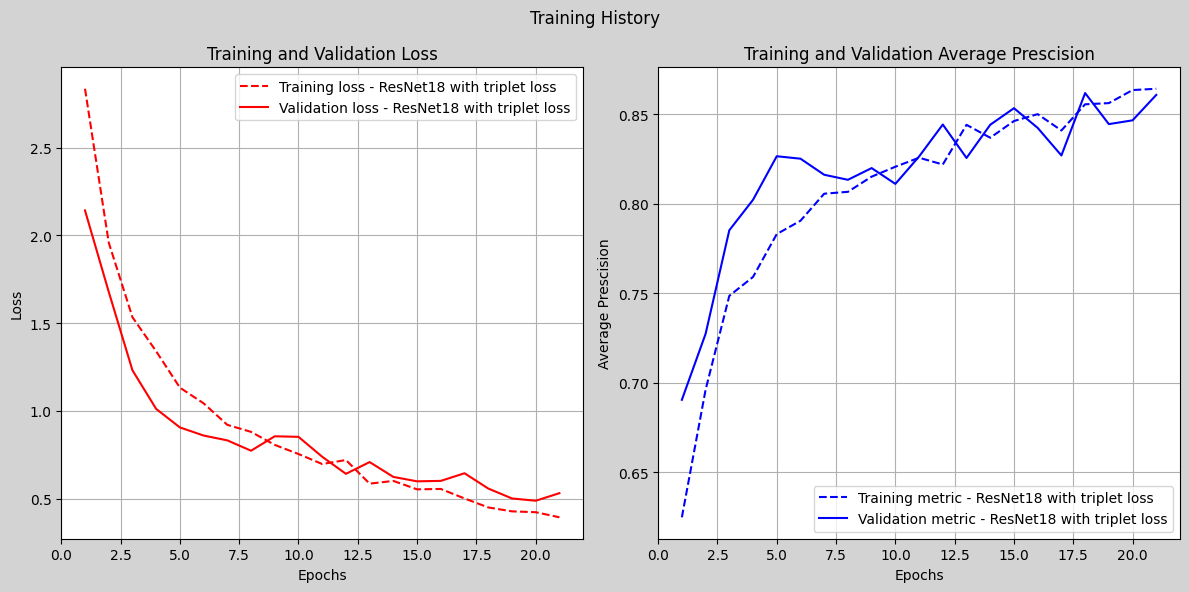

In [ ]:
plot_training_history([results], ['ResNet18 with triplet loss'], 'Average Prescision')

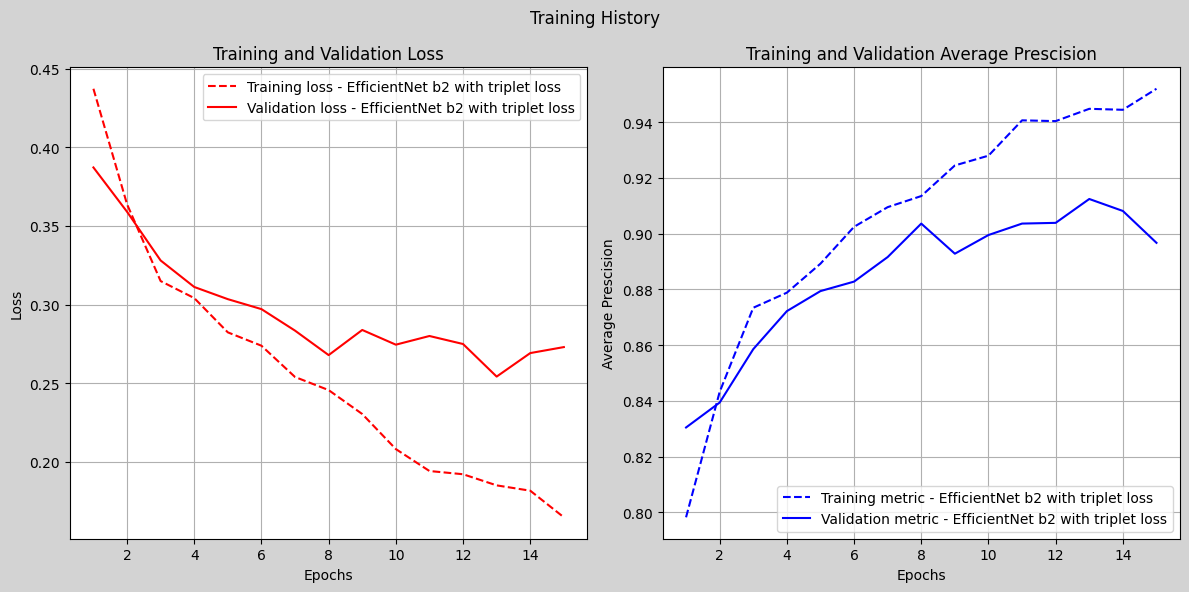

In [ ]:
plot_training_history([results], ['EfficientNet b2 with triplet loss'], 'Average Prescision')

In [ ]:
torch.save(model.state_dict(), 'resnet_model.pth')
FileLink(r'resnet_model.pth')

/kaggle/working/resnet_model.pth

In [ ]:
model.load_state_dict(torch.load('/kaggle/input/resnet-weights/resnet_model.pth'))

<All keys matched successfully>

# Identification rate

In [ ]:
f = open('/kaggle/input/ident-rate/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('/kaggle/input/ident-rate/celebA_ir/celebA_distractors')

In [ ]:
def compute_embeddings(model, images_list):
    '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
      '''

    class IR_Dataset(Dataset):
        def __init__(self, images_filepaths):
            self.images_filepaths = images_filepaths

        def __len__(self):
            return len(self.images_filepaths)

        def load_sample(self, file):
            image = Image.open(file)
            image.load()
            return image

        def __getitem__(self, index):
            transform = transforms.Compose([
                transforms.Resize(size=(224,224), antialias=True),
                transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
            x = self.load_sample(self.images_filepaths[index])
            x = transform(x)
            return x


    data = IR_Dataset(images_list)
    dataloader = DataLoader(data, batch_size=32, shuffle=False)

    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            embeddings.append(output)

    return embeddings

In [ ]:
path_query = '/kaggle/input/ident-rate/celebA_ir/celebA_query'
query_img_full_names = []
for line in query_img_names:
    full_path = os.path.join(path_query, line)
    query_img_full_names.append(full_path)

In [ ]:
path_distractors = '/kaggle/input/ident-rate/celebA_ir/celebA_distractors'
distractors_img_full_names = []
for line in distractors_img_names:
    full_path = os.path.join(path_distractors, line)
    distractors_img_full_names.append(full_path)

In [ ]:
query_embeddings = compute_embeddings(model, query_img_full_names)
distractors_embeddings = compute_embeddings(model, distractors_img_full_names)

In [ ]:
query_embeddings = torch.cat(query_embeddings, dim=0)
distractors_embeddings = torch.cat(distractors_embeddings, dim=0)

In [ ]:
query_embeddings.shape

torch.Size([1222, 512])

In [ ]:
query_dict = {}
for couple in query_lines:
    label = int(couple[1])
    query_dict.setdefault(label, [])
    query_dict[label].append(couple[0])

In [ ]:
def compute_cosine_query_pos(query_dictionary, query_img_names, query_embeddings):
    '''compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list'''
    name_to_embedding = {name: emb for name, emb in zip(query_img_names, query_embeddings)}
    labels = list(query_dictionary.keys())
    scores = []
    for label in labels:
        for i in range(len(query_dictionary[label])):
            for j in range(i+1, len(query_dictionary[label])):
                first_embedding = name_to_embedding[query_dictionary[label][i]]
                second_embedding = name_to_embedding[query_dictionary[label][j]]

                cos_sim = F.cosine_similarity(first_embedding.unsqueeze(0), second_embedding.unsqueeze(0))
                scores.append(cos_sim.item())
    return scores

def compute_cosine_query_neg(query_dictionary, query_img_names, query_embeddings):
    '''compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list'''
    name_to_embedding = {name: emb for name, emb in zip(query_img_names, query_embeddings)}
    labels = list(query_dictionary.keys())
    scores = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            label_i = labels[i]
            label_j = labels[j]

            for img_i in query_dictionary[label_i]:
                for img_j in query_dictionary[label_j]:
                    emb_i = name_to_embedding[img_i]
                    emb_j = name_to_embedding[img_j]

                    cos_sim = F.cosine_similarity(emb_i.unsqueeze(0), emb_j.unsqueeze(0))
                    scores.append(cos_sim.item())
    return scores

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors'''
    scores = []
    for query in query_embeddings:
        for distractor in distractors_embeddings:
            cos_sim = F.cosine_similarity(query.unsqueeze(0), distractor.unsqueeze(0))
            scores.append(cos_sim.item())
    return scores

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

## check

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = torch.tensor([
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
])

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = torch.tensor([
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
])

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr params:
        cosine_query_pos: cosine similarities between positive pairs from query
        cosine_query_neg: cosine similarities between negative pairs from query
        cosine_query_distractors: cosine similarities between negative pairs
                                  from query and distractors
    fpr: false positive rate at which to compute TPR output:
        float: threshold for given fpr
        float: TPR at given FPR
    '''

    all_negatives = np.array(cosine_query_neg + cosine_query_distractors)

    # Compute the threshold for the given FPR
    threshold = np.percentile(all_negatives, 100 * (1 - fpr))

    # Compute TPR at this threshold
    cosine_query_pos = np.array(cosine_query_pos)
    true_positives = np.sum(cosine_query_pos >= threshold)
    tpr = true_positives / len(cosine_query_pos)

    return threshold, tpr

## check

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

In [ ]:
compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors)

(0.8545250713825225, 0.2937300455132124)

In [ ]:
fpr = [0.5, 0.2, 0.1, 0.05]
tpr = []
for value in fpr:
    tpr.append(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, value)[1])

In [ ]:
tpr

[0.8356089939542151,
 0.4869234427009035,
 0.2937300455132124,
 0.1690102574553359]

In [ ]:
def plot_graph(tpr, fpr):
    plt.figure(figsize=(8, 6))
    plt.plot(tpr, fpr, marker='o', linestyle='-', color='red')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.title('TPR@FPR')
    plt.grid(True)
    plt.show()


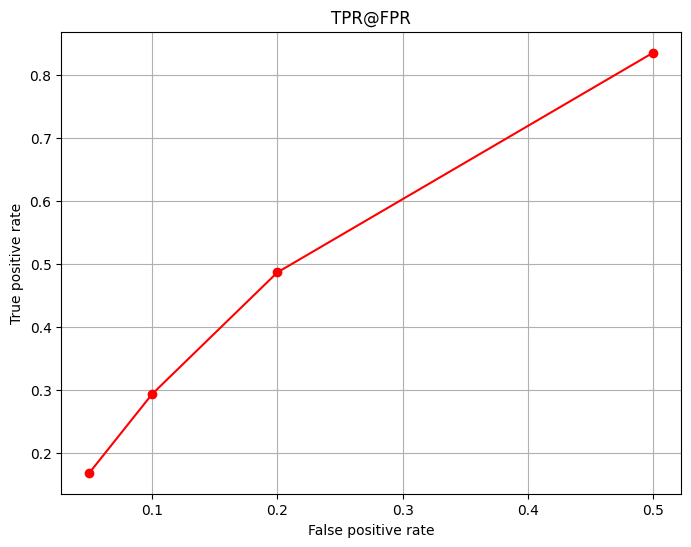

In [ ]:
plot_graph(fpr, tpr)

# У меня возникла идея провести понижение размерности и посмотреть как группируются на плоскости эммбединги один и тех же классов (возьмем первые 10 классов например), я думаю они должны образовывать скопления, посмотрим:

In [ ]:
first_ten_classes = []
for i in range(10):
    for j in range(len(id_dict[i])):
        first_ten_classes.append(id_dict[i][j])

In [ ]:
temp_dataset = Faces(first_ten_classes, 'test')
temp_loader = DataLoader(temp_dataset, batch_size=1) # так удобнее, сделаем лоудер который по 1 батчу выдает

In [ ]:
latent_vectors = [] # создаем список, куда будем грузить значение латентного пространства и цифру которую она репрезентирует
for batch, true in temp_loader:
    batch = batch.to(device)
    latent_vectors.append([model(batch), true.item()])

In [ ]:
latent_dict = {} # переводим все в словарь, так удобнее: ключи это классы, а значения это список латентных векторов которые соответствуют этому классу
for couple in latent_vectors:
    latent_dict.setdefault(couple[1], [])
    latent_dict[couple[1]].append(couple[0].cpu().detach().numpy()) # сразу переводим все в нумпай массив

In [ ]:
all_vectors = [] # далее нужно будет создать список всех вообще лат векторов что бы в конце концов сделать матрицу и загрузить ее в tSNE
latent_sizes = [0] * 10 # тут будут храниться длины срезов каждого числа
for key in range(10):
    for values in range(len(latent_dict[key])):
        all_vectors.append(latent_dict[key][values][0])
    latent_sizes[key] = len(latent_dict[key])

In [ ]:
latent_matrix = np.vstack(all_vectors) # получаем желанную матрицу

In [ ]:
latent_sizes

[30, 30, 30, 30, 25, 30, 30, 30, 30, 29]

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)

latent_vectors_2d = tsne.fit_transform(latent_matrix) # получаем двумерное представление векторов

In [ ]:
from matplotlib.lines import Line2D
def plot_latent_space(latent_vectors_2d):
    plt.figure(figsize=(10, 8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    labels = [i for i in range(10)]

    plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=np.repeat(colors, latent_sizes), alpha=0.5)

    labels = [str(i) for i in range(10)]  # Метки от 0 до 9

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, labels)]
    plt.legend(handles=legend_elements, title='Digits')

    plt.title('t-SNE Projection of Latent Vectors')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

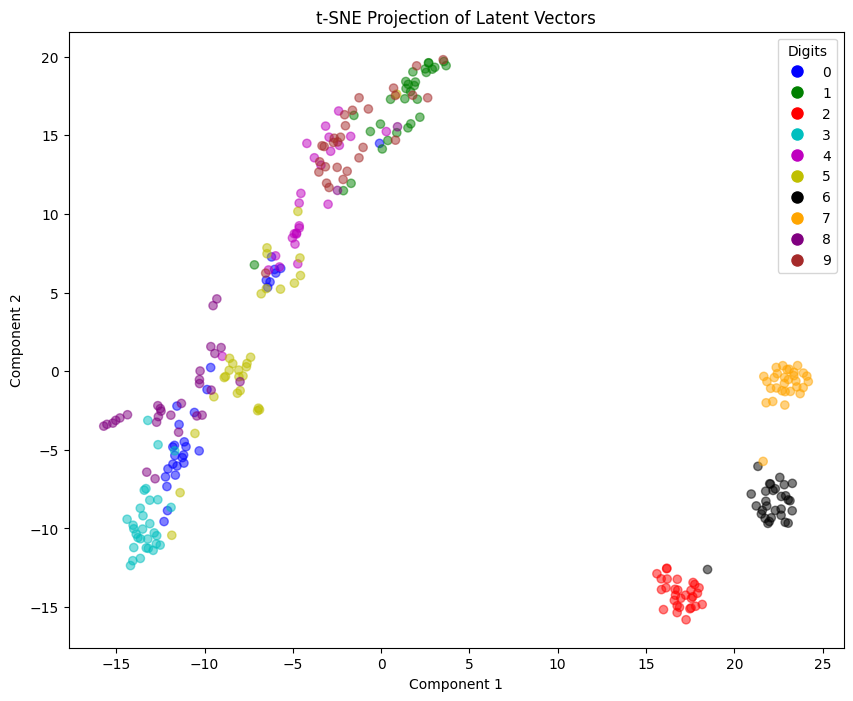

In [ ]:
plot_latent_space(latent_vectors_2d)

## получилось забавно) 7-й, 6-й и 2-й классы прям в отдельном угле и хорошо сгруппированы, а остальные образуют дугу постепенно и плавно переходя друг в друга

# Вернемся к задаче классификации и попробуем улучшим результат что бы результат на тестовой части был более 0.7. Это нужно во первых получить желаемый результат, а во вторых я хочу получить хороший backbone, который дает приемлимые результаты с CE loss, что бы потом уже использовать arcface loss и показать явно что результат улучшился с теми же настройками и тем же backbone'ом

In [ ]:
batch_size = 64
num_workers = 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
  )

val_dataloader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

test_dataloader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

In [ ]:
#!pip install efficientnet_pytorch
#from efficientnet_pytorch import EfficientNet
EN_model = EfficientNet.from_pretrained('efficientnet-b2')

Loaded pretrained weights for efficientnet-b2


In [ ]:
EN_layers = [name for name, _ in EN_model.named_parameters()]
len(EN_layers)

301

In [ ]:
freeze = EN_layers[:90]
for name, param in EN_model.named_parameters():
    if name in freeze:
        param.requires_grad = False

# изменим классификационную голову на 500 классов
num_ftrs = EN_model._fc.in_features
EN_model._fc = nn.Linear(num_ftrs, 500)

summary(EN_model,
        input_size=(64, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 500]            --                   Partial
├─Conv2dStaticSamePadding (_conv_stem)                       [64, 3, 224, 224]    [64, 32, 112, 112]   864                  False
│    └─ZeroPad2d (static_padding)                            [64, 3, 224, 224]    [64, 3, 225, 225]    --                   --
├─BatchNorm2d (_bn0)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   (64)                 False
├─MemoryEfficientSwish (_swish)                              [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   Partial
│    └─MBConvBlock (0)                                       [64, 32, 112, 112]   [64, 1

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(EN_model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 7, gamma=0.5)
n_epochs = 15

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = train(model=EN_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.6752 | train_acc: 0.0557 | test_loss: 4.6693 | test_acc: 0.1051
Epoch: 2 | train_loss: 3.7466 | train_acc: 0.2826 | test_loss: 3.1125 | test_acc: 0.3547
Epoch: 3 | train_loss: 2.3289 | train_acc: 0.5516 | test_loss: 2.3833 | test_acc: 0.4985
Epoch: 4 | train_loss: 1.4122 | train_acc: 0.7374 | test_loss: 1.9127 | test_acc: 0.5829
Epoch: 5 | train_loss: 0.8202 | train_acc: 0.8583 | test_loss: 1.6461 | test_acc: 0.6333
Epoch: 6 | train_loss: 0.4707 | train_acc: 0.9287 | test_loss: 1.4592 | test_acc: 0.6700
Epoch: 7 | train_loss: 0.2896 | train_acc: 0.9611 | test_loss: 1.3766 | test_acc: 0.6833
Epoch: 8 | train_loss: 0.1922 | train_acc: 0.9781 | test_loss: 1.3223 | test_acc: 0.6949
Epoch: 9 | train_loss: 0.1410 | train_acc: 0.9850 | test_loss: 1.2593 | test_acc: 0.7091
Epoch: 10 | train_loss: 0.1033 | train_acc: 0.9904 | test_loss: 1.2342 | test_acc: 0.7180
Epoch: 11 | train_loss: 0.0812 | train_acc: 0.9922 | test_loss: 1.1803 | test_acc: 0.7289
Epoch: 12 | train_l

In [ ]:
test_step(EN_model, test_dataloader, loss_fn, device)

(1.2605127692222595, 0.7332589285714286)

### Класс! получилось, долго очень я подбирал модель методом проб и ошибок

In [ ]:
torch.save(EN_model.state_dict(), 'EN_b2.pth')
FileLink(r'EN_b2.pth')

/kaggle/working/EN_b2.pth

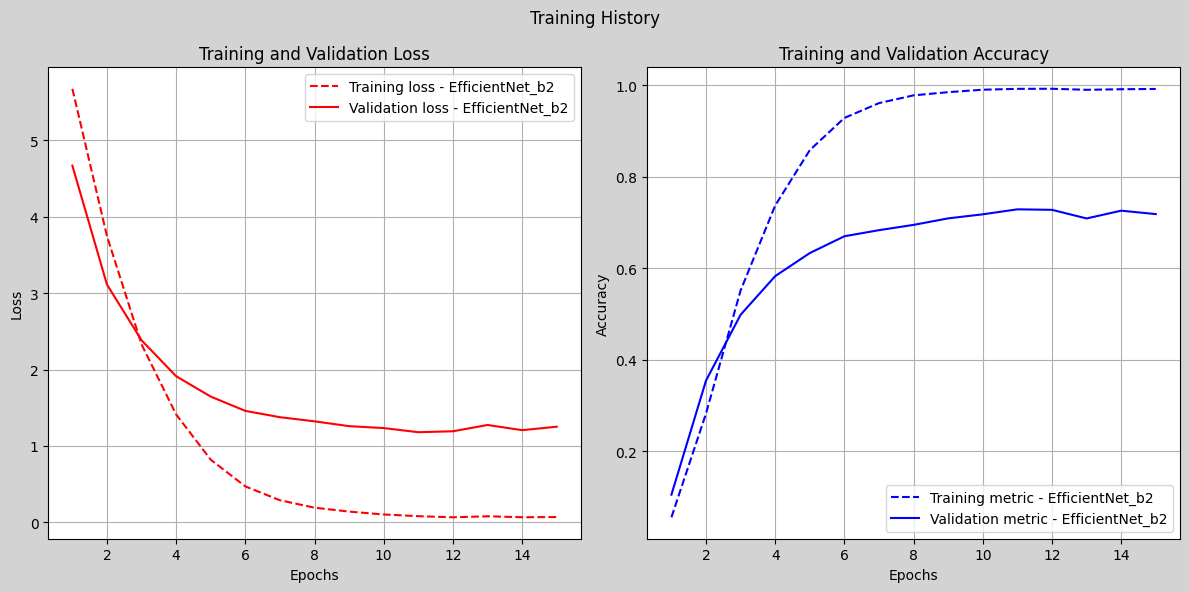

In [ ]:
plot_training_history([results], ['EfficientNet_b2'])

# Additive Angular Margin Loss (ArcFace Loss)

In [ ]:
class ArcFaceLoss(torch.nn.Module):
    def __init__(self, n_classes=500, sphere_radius=64.0, margin=5e-1):
        super(ArcFaceLoss, self).__init__()
        # количество классов
        self.n_classes = n_classes
        # радиус представляет из себя радиус гиперсферы который используется для масштабирования логитов.
        self.radius     = sphere_radius
        # margin - угловое смещение добавляемое к эмбеддингам для лучшего разделения классов
        self.cos_margin = np.cos(margin) # соответственно это косинус
        self.sin_margin = np.sin(margin) # а это синус этого смещения

        # основа - CE loss
        self.cross_entropy = torch.nn.CrossEntropyLoss()


    def forward(self, logits, labels):
        # target_mask как видно из кода это матрица векторов классов кодируемая как one-hot вектора (единица на месте правильного класса, остальное нули)
        target_mask = torch.nn.functional.one_hot(labels, self.n_classes)

        logits = F.normalize(logits, dim=1)
        # стоить обратить внимание: если вектор логитов не нормализован предварительно то Loss будет выдавать nan'ы спокойно,
        # потому что появиться рано или поздно отрицательно значение под корнем.
        sin_theta = torch.sqrt(1.0 - torch.pow(logits, 2))
        # вычисляются измененные значения логитов для целевых классов с использованием углового смещения
        arc_logits_target = logits * self.cos_margin - sin_theta * self.sin_margin
        # Объединяются измененные логиты целевых классов и исходные логиты для всех остальных классов. Масштабируются с использованием радиуса гиперсферы
        arc_logits = self.radius * ( (1-target_mask)*logits + target_mask*arc_logits_target )

        loss = self.cross_entropy(arc_logits, labels)

        return loss

In [ ]:
class ModifiedEfficientNet(nn.Module):
    def __init__(self, num_classes=500, embedding_dim=512):
        super(ModifiedEfficientNet, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b2')

        self.EN_layers = [name for name, _ in self.efficientnet.named_parameters()]
        self.freeze = self.EN_layers[:90]
        for name, param in self.efficientnet.named_parameters():
            if name in self.freeze:
                param.requires_grad = False

        # Изменяем последний слой EfficientNet на Linear слой с нужным размером эмбеддингов
        self.efficientnet._fc = nn.Linear(self.efficientnet._fc.in_features, embedding_dim)

        # Добавляем классификационную голову
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        embeddings = F.normalize(self.efficientnet(x), dim=1)
        logits = self.classifier(embeddings)
        return logits, embeddings

In [ ]:
# опять тот же трейн луп, но тут модель возвращает как эмбеддинги так и логиты, так что правим:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_acc = 0
    train_loss = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output, _ = model(inputs)

        loss = loss_fn(output, labels.long())
        loss.backward()
        optimizer.step()
        accuracy = calculate_accuracy(output, labels)
        train_acc += accuracy
        train_loss += loss.item()
    return (train_loss/len(dataloader), train_acc/len(dataloader))

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_acc = 0
    test_loss = 0
    best_acc = - np.inf
    best_weights = None
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            output, _ = model(inputs)
            loss = loss_fn(output, labels.long())
            accuracy = calculate_accuracy(output, labels)
            test_acc += accuracy
            test_loss += loss.item()

    return (test_loss/len(dataloader), test_acc/len(dataloader))



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    best_acc = - np.inf
    best_weights = None
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        if test_acc > best_acc:
            best_acc = test_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )


        results['train_loss'].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        model.load_state_dict(best_weights)
        torch.save({
                'epoch': epochs,
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, f"{epochs}_iter.pth")

    return results

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=eca0ed2fc912d6a7c2f88d00afc6f7fc5eef48c193566d093470f0c01a75cb18
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EN_model = ModifiedEfficientNet().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 230MB/s]


Loaded pretrained weights for efficientnet-b2


In [ ]:
loss_fn = ArcFaceLoss()
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(EN_model.parameters(), lr=2e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 22, gamma=0.5) # добавим lr-reductor))
n_epochs = 21

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=EN_model.to(device),
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 36.3692 | train_acc: 0.0668 | test_loss: 34.4637 | test_acc: 0.2243
Epoch: 2 | train_loss: 33.3134 | train_acc: 0.3562 | test_loss: 32.1952 | test_acc: 0.4233
Epoch: 3 | train_loss: 29.8490 | train_acc: 0.5911 | test_loss: 29.5799 | test_acc: 0.5538
Epoch: 4 | train_loss: 26.1598 | train_acc: 0.7340 | test_loss: 27.3658 | test_acc: 0.5960
Epoch: 5 | train_loss: 22.5980 | train_acc: 0.8182 | test_loss: 24.9689 | test_acc: 0.6337
Epoch: 6 | train_loss: 19.4936 | train_acc: 0.8663 | test_loss: 22.9488 | test_acc: 0.6494
Epoch: 7 | train_loss: 16.5797 | train_acc: 0.9020 | test_loss: 20.9085 | test_acc: 0.6926
Epoch: 8 | train_loss: 14.1158 | train_acc: 0.9244 | test_loss: 18.8292 | test_acc: 0.7279
Epoch: 9 | train_loss: 11.8074 | train_acc: 0.9409 | test_loss: 17.5291 | test_acc: 0.7289
Epoch: 10 | train_loss: 9.7893 | train_acc: 0.9500 | test_loss: 16.5762 | test_acc: 0.7445
Epoch: 11 | train_loss: 8.0337 | train_acc: 0.9631 | test_loss: 15.2706 | test_acc: 0.7702

In [ ]:
test_step(EN_model, test_dataloader, loss_fn, device)

(12.71611875295639, 0.82421875)

## Результат значительно улучшился

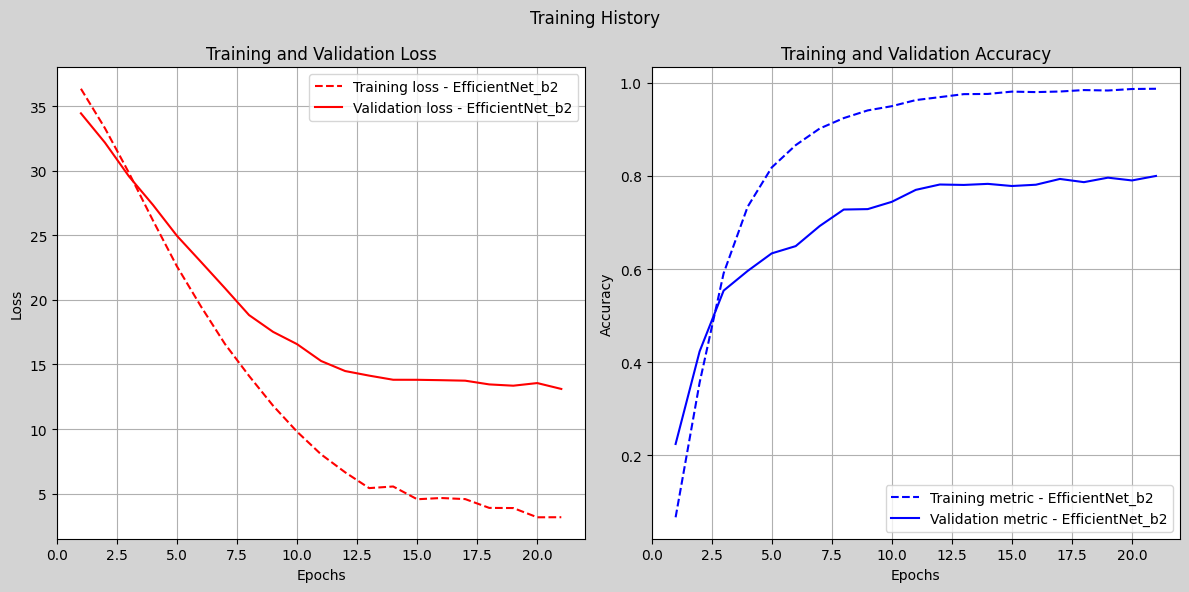

In [ ]:
plot_training_history([results], ['EfficientNet_b2'])

## Снова посмотрим как выглядят эмбеддинги на плоскости: к сожалению я не смог повторно запустить этот код, ибо у меня начала постоянно вылетать ошибка CUDA out of memory. Благо я заскринил результат, так что предоставляю его:

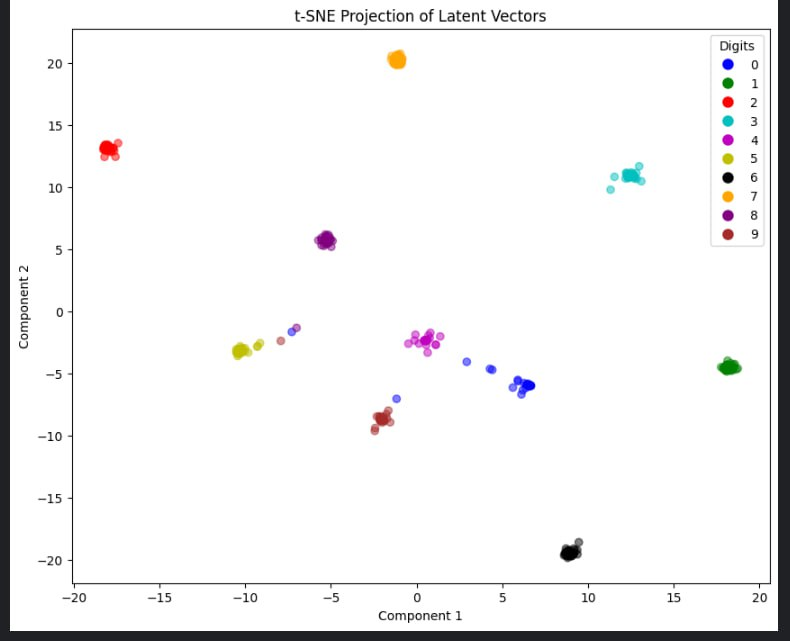

## получилось очень наглядно, мне понравилось!